In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

In [ ]:
# Load pre-trained T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Load the imbalanced dataset
df = pd.read_csv("/content/Derby_new.csv")

# Inspect the dataset
print(df.head())

# Check class distribution
print(df['label'].value_counts())

                                         description  label
0  Reporting for Army  filed on derby-dev list.If...      0
1  Opening this bug on behalf of Daniel Debrunner...      0
2  Since LOCKS is not a reserved keyword in SQL s...      0
3  When using derby database encryption there is ...      1
4  Request to have support forSelect * from foo w...      0
label
0    821
1    179
Name: count, dtype: int64


In [ ]:
df = df.dropna(subset=['description'])

In [ ]:
df['description'] = df['description'].str.lower()

In [ ]:
import re
df['description'] = df['description'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+', '', x, flags=re.MULTILINE))
df['description'] = df['description'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)
df['description'] = df['description'].str.strip()

In [ ]:
import nltk
nltk.download('wordnet')  # Download the WordNet corpus
nltk.download('omw-1.4')  # Optional: Download multilingual WordNet data
nltk.download('stopwords')  # For stopwords, if not already downloaded
nltk.download('punkt')  # For tokenization, if not already downloaded
nltk.download('punkt_tab')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize
df['tokens'] = df['description'].apply(word_tokenize)

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

In [ ]:
from nltk.stem import PorterStemmer
ps = PorterStemmer()
df['tokens'] = df['tokens'].apply(lambda x: [ps.stem(word) for word in x])

In [ ]:
df['description'] = df['tokens'].apply(lambda x: ' '.join(x))

In [ ]:
def generate_augmented_text(input_text, num_return_sequences=3):
    """
    Generates augmented text using T5 for text transformation.
    """
    # Prepare input for T5
    input_ids = tokenizer.encode(f"paraphrase: {input_text} </s>", return_tensors="pt").to(device)

    # Generate augmented text
    outputs = model.generate(
        input_ids,
        max_length=50,
        num_return_sequences=num_return_sequences,
        num_beams=5,
        temperature=1.5,
        top_k=50,
        top_p=0.95,
        repetition_penalty=2.0
    )

    # Decode generated text
    augmented_texts = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return augmented_texts

In [ ]:
def augment_minority_class_balanced(df, text_col="text", label_col="label", minority_label=1, num_augmentations=3):
    """
    Augments the minority class examples in the dataset to balance the class distribution.
    """
    # Calculate the difference between majority and minority class
    majority_class_count = df[df[label_col] == 0].shape[0]
    minority_class_count = df[df[label_col] == minority_label].shape[0]
    samples_needed = majority_class_count - minority_class_count

    print(f"Majority class: {majority_class_count}, Minority class: {minority_class_count}")
    print(f"Samples needed to balance: {samples_needed}")

    # List to store augmented samples
    augmented_texts = []

    # Loop through the minority class examples
    for _, row in df[df[label_col] == minority_label].iterrows():
        original_text = row[text_col]
        # Generate augmented samples
        augmented_samples = generate_augmented_text(original_text, num_return_sequences=num_augmentations)

        # Add augmented samples to the list
        for augmented_text in augmented_samples:
            if len(augmented_texts) < samples_needed:  # Stop when enough samples are added
                augmented_texts.append({text_col: augmented_text, label_col: minority_label})
            else:
                break  # Exit early if enough samples are generated

        if len(augmented_texts) >= samples_needed:
            break  # Stop once we have enough samples

    # Create a DataFrame for augmented texts
    augmented_df = pd.DataFrame(augmented_texts)

    # Combine augmented data with the original dataset
    return pd.concat([df, augmented_df], ignore_index=True)

In [ ]:
pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 10.7 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
# Dynamically calculate the number of augmentations needed per sample
def augment_minority_class_balanced_dynamic(df, text_col, label_col, minority_label, majority_count):
    """
    Dynamically augment the minority class to balance with the majority class.

    Parameters:
        df (pd.DataFrame): Original dataset.
        text_col (str): Column containing text data.
        label_col (str): Column containing class labels.
        minority_label (int or str): Value representing the minority class.
        majority_count (int): Count of majority class samples.

    Returns:
        pd.DataFrame: Balanced dataset.
    """
    import random
    from nlpaug.augmenter.word import SynonymAug

    # Initialize the augmenter
    augmenter = SynonymAug(aug_src='wordnet')

    # Separate majority and minority classes
    minority_df = df[df[label_col] == minority_label]
    majority_df = df[df[label_col] != minority_label]

    # Calculate number of samples needed to balance
    samples_needed = majority_count - len(minority_df)

    # Generate augmented samples
    augmented_texts = []
    augmented_labels = []

    for _ in range(samples_needed):
        # Randomly select a sample from the minority class
        original_text = random.choice(minority_df[text_col].values)
        # Augment the text
        augmented_text = augmenter.augment(original_text)
        augmented_texts.append(augmented_text)
        augmented_labels.append(minority_label)

    # Create a DataFrame for the augmented data
    augmented_df = pd.DataFrame({
        text_col: augmented_texts,
        label_col: augmented_labels
    })

    # Concatenate original and augmented data
    balanced_df = pd.concat([df, augmented_df], ignore_index=True)

    return balanced_df

# Dynamically augment and balance the dataset
majority_count = df["label"].value_counts().max()
balanced_df = augment_minority_class_balanced_dynamic(
    df,
    text_col="description",      # Replace with your text column name
    label_col="label",           # Replace with your label column name
    minority_label=1,            # Replace with the actual value of your minority class
    majority_count=majority_count
)

# Check class distribution after augmentation
print("After Augmentation:")
print(balanced_df["label"].value_counts())

After Augmentation:
label
0    821
1    821
Name: count, dtype: int64


In [ ]:
# Save the augmented dataset to a CSV file
balanced_df.to_csv("augmented_dataset.csv", index=False)
print("Augmented dataset saved to 'augmented_dataset.csv'.")

Augmented dataset saved to 'augmented_dataset.csv'.


In [ ]:
import pandas as pd

# Assuming real_data and balanced_data are DataFrames
# Select only numeric columns for the calculation
real_data_numeric = df.select_dtypes(include=['float64', 'int64'])
balanced_data_numeric = balanced_df.select_dtypes(include=['float64', 'int64'])

# Ensure there are no missing values in the numeric columns (optional, but recommended)
real_data_numeric = real_data_numeric.fillna(0)  # Replace NaN with 0 (or other method)
balanced_data_numeric = balanced_data_numeric.fillna(0)

# Calculate mean and variance
real_mean = real_data_numeric.mean()
balanced_mean = balanced_data_numeric.mean()

real_variance = real_data_numeric.var()
balanced_variance = balanced_data_numeric.var()

# Calculate differences
mean_difference = balanced_mean - real_mean
variance_difference = balanced_variance - real_variance

print("Mean Difference:\n", mean_difference)
print("Variance Difference:\n", variance_difference)

Mean Difference:
 label    0.321
dtype: float64
Variance Difference:
 label    0.103046
dtype: float64


In [ ]:
from scipy.stats import ks_2samp

# Perform KS Test for each feature
for column in real_data_numeric.columns:
    statistic, p_value = ks_2samp(real_data_numeric[column], balanced_data_numeric[column])
    print(f"Feature: {column}, KS Statistic: {statistic}, p-value: {p_value}")

Feature: label, KS Statistic: 0.321, p-value: 3.62980453365953e-57


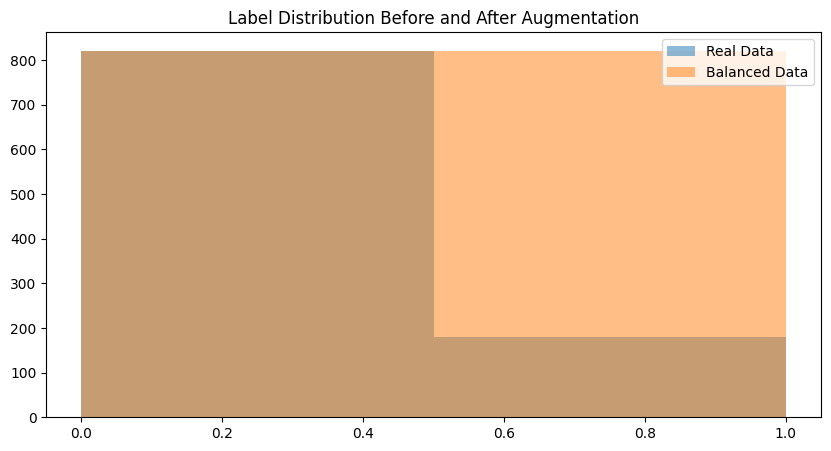

In [ ]:
import matplotlib.pyplot as plt

# Plot label distributions
plt.figure(figsize=(10, 5))
plt.hist(df['label'], bins=2, alpha=0.5, label='Real Data')
plt.hist(balanced_df['label'], bins=2, alpha=0.5, label='Balanced Data')
plt.legend(loc='upper right')
plt.title('Label Distribution Before and After Augmentation')
plt.show()

In [ ]:
for column in real_data_numeric.columns:
    statistic, p_value = ks_2samp(real_data_numeric[column], balanced_data_numeric[column])
    print(f"Feature: {column}, KS Statistic: {statistic}, p-value: {p_value}")

Feature: label, KS Statistic: 0.321, p-value: 3.62980453365953e-57


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

In [ ]:
# Load balanced dataset
df = balanced_df

# Split into train and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['description'], df['label'], test_size=0.2, random_state=42
)

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
train_texts = train_texts.astype(str).tolist()
test_texts = test_texts.astype(str).tolist()

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

In [ ]:
# Convert to PyTorch datasets
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, list(train_labels))
test_dataset = TextDataset(test_encodings, list(test_labels))

In [ ]:
# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,No log,0.281758
2,No log,0.233381
3,No log,0.220453
4,No log,0.365765
5,No log,0.251837


TrainOutput(global_step=415, training_loss=0.19941989025437687, metrics={'train_runtime': 484.4931, 'train_samples_per_second': 13.55, 'train_steps_per_second': 0.857, 'total_flos': 431831019609600.0, 'train_loss': 0.19941989025437687, 'epoch': 5.0})

In [ ]:
# Evaluate
trainer.evaluate()

{'eval_loss': 0.2518370449542999,
 'eval_runtime': 2.2816,
 'eval_samples_per_second': 144.199,
 'eval_steps_per_second': 2.63,
 'epoch': 5.0}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import numpy as np

In [ ]:
# Assuming you have a test dataset and a trained model
raw_preds = trainer.predict(test_dataset)  # test_dataset should be a processed Dataset object
predictions = np.argmax(raw_preds.predictions, axis=1)  # Convert logits to class labels
labels = raw_preds.label_ids  # True labels

In [ ]:
# Calculate metrics
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions, average='binary')  # Change 'binary' to 'macro' for multi-class
recall = recall_score(labels, predictions, average='binary')
f1 = f1_score(labels, predictions, average='binary')
roc_auc = roc_auc_score(labels, raw_preds.predictions[:, 1])  # Use raw scores for ROC-AUC (binary classification)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.9179
Precision: 0.9247
Recall: 0.8940
F1-Score: 0.9091
ROC-AUC: 0.9739


In [ ]:
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=["Class 0", "Class 1"]))


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.94      0.93       178
     Class 1       0.92      0.89      0.91       151

    accuracy                           0.92       329
   macro avg       0.92      0.92      0.92       329
weighted avg       0.92      0.92      0.92       329



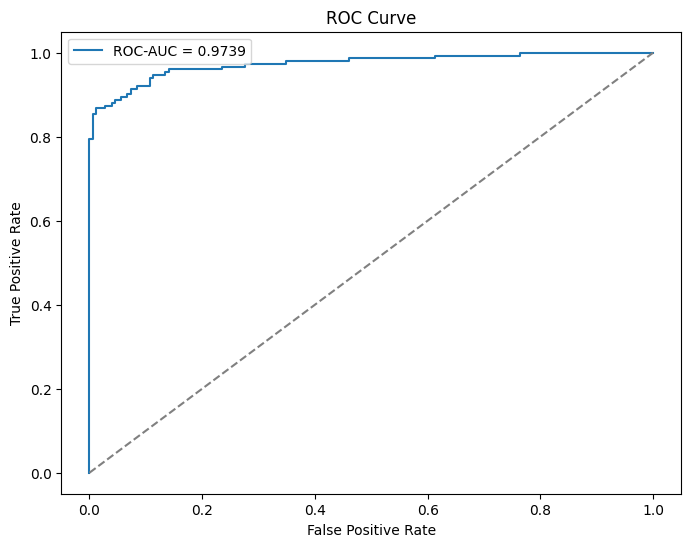

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(labels, raw_preds.predictions[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("roc_curve_derby.png", dpi=300, bbox_inches="tight")
plt.show()

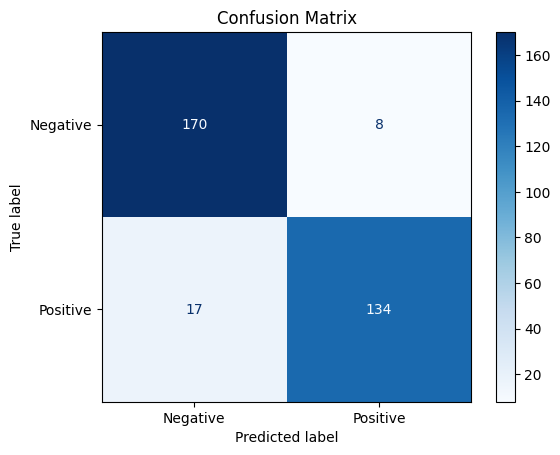

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Set a threshold (e.g., 0.5)
threshold = 0.5

# Convert raw predictions to binary predictions
binary_preds = (raw_preds.predictions[:, 1] >= threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(labels, binary_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix_derby.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import shap

In [ ]:
# Ensure test_texts_subset is a list of raw strings
test_texts_subset = test_texts[:10]  # Adjust subset size as needed
print(type(test_texts_subset))  # Should be <class 'list'>
print(type(test_texts_subset[0]))  # Should be <class 'str'>

<class 'list'>
<class 'str'>


In [ ]:
import torch

def shap_predict_single(texts):
    # Convert to list if a single string is provided
    if isinstance(texts, str):
        texts = [texts]

    # Ensure texts is a list of strings before tokenization
    texts = [str(text) for text in texts]  # Convert each element to string if needed

    # Tokenize input text
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )

    # Move both model and encodings to the same device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define device
    model.to(device) # Move model to device
    encodings = encodings.to(device) # Move encodings to device

    # Model inference
    with torch.no_grad():
        outputs = model(**encodings)
        probabilities = torch.softmax(outputs.logits, dim=1)

    return probabilities.cpu().numpy()

In [ ]:
explainer = shap.Explainer(shap_predict_single, tokenizer)

In [ ]:
input_text = "support hadoop secur frontend chang"

In [ ]:
shap_values = explainer([input_text])

In [ ]:
shap_html_output = shap.plots.text(shap_values[0])

In [ ]:
pip install lime transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f0dbb73e3c58b1cf29a5db7c6d06a5778591498d58538f993b2bf8c65741ef71
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from lime.lime_text import LimeTextExplainer

# Load the pre-trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Custom prediction function for LIME
def predict_with_model_lime(texts):
    encodings = tokenizer(
        texts,
        padding=True,            # Padding argument
        truncation=True,         # Ensure truncation to max length
        max_length=128,          # Maximum length for truncation
        return_tensors="pt"      # Return as PyTorch tensors
    ).to(device)

    with torch.no_grad():
        outputs = model(**encodings)
        probabilities = torch.softmax(outputs.logits, dim=1)

    return probabilities.cpu().numpy()

# Initialize the LimeTextExplainer
explainer = LimeTextExplainer(class_names=['negative', 'positive'])

# Example text input for explanation
input_text = ["A vulnerability was found in ImageMagick 70834 has a use of uninitialized value vulnerability in the SyncImageSettings function in MagickCoreimagec This is related to AcquireImage in magickimagec Reference "]

# Generate LIME explanation for the input text
explanation = explainer.explain_instance(input_text[0], predict_with_model_lime, num_features=10)

# Show the explanation
explanation.show_in_notebook()

# You can also get the explanation in a more readable format:
print("LIME Explanation:")
print(explanation.as_list())

import matplotlib.pyplot as plt

# Generate and plot the explanation
fig = explanation.as_pyplot_figure()

# Save the figure with high resolution (DPI 300)
fig.savefig("lime_explanation.png", dpi=300, bbox_inches="tight")

print("LIME explanation saved as 'lime_explanation.png'")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.03 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.22 GiB is free. Process 7871 has 12.53 GiB memory in use. Of the allocated memory 10.58 GiB is allocated by PyTorch, and 1.82 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Generate LIME explanation for the negative class
explanation = explainer.explain_instance(
    input_text[0],
    predict_with_model_lime,
    num_features=10,
    labels=[0]  # Focus on the negative class (class 0)
)

# Show the explanation for the negative class
explanation.show_in_notebook(label=0)

# Save the explanation as a plot for the negative class
fig = explanation.as_pyplot_figure(label=0)
fig.savefig("lime_explanation_negative.png", dpi=300, bbox_inches="tight")
print("LIME explanation for negative class saved as 'lime_explanation_negative.png'")


OutOfMemoryError: CUDA out of memory. Tried to allocate 3.03 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.98 GiB is free. Process 7871 has 11.77 GiB memory in use. Of the allocated memory 8.60 GiB is allocated by PyTorch, and 3.04 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)